In [1]:
import numpy as np
from qiskit import *
import random
import time
from numpy import log as ln
import warnings
warnings.filterwarnings('ignore', module = 'qiskit')
# warnings.filterwarnings(action='once')

from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC, CG, L_BFGS_B, GSLS, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One

In [2]:
# Generate Primes as an array
primes = [2,3,5]#,7,11,17,19,,31,37]
primes = primes[::-1]

In [3]:
# Generate Quantum Circuit single layer
def generate_circuit(params, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/(4 * len(primes)))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(len(primes) * 4 *layers)]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, len(primes) * 4))
    params = np.reshape(np.asarray(params),(layers, len(primes) * 4))
#     cir.x(0)
#     cir.x(1)
#     cir.x(2)
#     cir.x(3)
#     cir.x(4)
#     cir.x(5)
#     cir.x(6)
#     cir.h(range(len(primes)))
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0:int(l/4)]
        b = thetas_reshape[m][int(l/4): int(2*l/4)]
        a = thetas_reshape[m][int(2*l/4): int(3*l/4)]
        t = thetas_reshape[m][int(3*l/4):l]

        for i in range(len(primes)):
            cir.ry(g[i], i)
        for j in range(len(primes)):
            if j != 0:
                cir.crz(b[j], j-1, j)
            else:
                cir.crz(b[j], len(primes)-1, j)
        for k in range(len(primes)):
            cir.ry(a[k], k)
        for o in range(len(primes)):
            cir.rx(t[o], o)
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

In [4]:
def generate_ZZcircuit(params, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/(3 * len(primes) - 1))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(layers * (3 * len(primes) - 1))]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, 3 * len(primes) - 1))
    params = np.reshape(np.asarray(params),(layers, 3 * len(primes) - 1))
    
    cir.h(range(len(primes)))
    
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0: len(primes)]
        a = thetas_reshape[m][len(primes): (2*len(primes))-1]
        b = thetas_reshape[m][(2*len(primes))-1 : (3 * len(primes)) -1]
        
        for h in range(len(primes)):
            cir.rz(g[h], h)            
        for i in range(1, len(primes)):
            cir.rzz(a[i-1], i-1, i)
        for j in range(len(primes)):
            cir.rx(b[j], j)
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[0.23561327149497124, 2.8495128463487966, 2.9389100544247815, 0.303759917553502, 2.911630229916881, 2.3669438521609236, 2.4763138315224307, 1.7580088852128415]


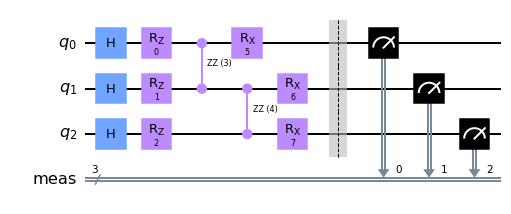

In [5]:
hyperparam = [random.uniform(0,np.pi) for _ in range((3 * len(primes) - 1) * 1)]
print(hyperparam)
cir, free_params = generate_ZZcircuit(hyperparam, assigned=False)
cir.draw('mpl')

In [6]:
def obj_function(counts, n, penalty):
    max_c = 0
    max_bit = ""
    for c in counts:
        if counts[c] >= max_c:
            max_c =  counts[c]
            max_bit = c
    comp_primes = 1
    for i in range(len(max_bit)):
        comp_primes *= primes[i]**int(max_bit[i])
    p = 0
    if penalty == 1:
        if comp_primes > n:
            p += comp_primes ** 2
#     print(comp_primes, n-comp_primes, p)
    return (n - comp_primes) + p

In [7]:
def f(theta):
    n = 16
    qc, free_params = generate_ZZcircuit(theta)
    back = Aer.get_backend('aer_simulator')
    back.set_options(device='GPU')
    job_sim = execute(qc, backend = back, shots = 2048).result()
    counts = job_sim.get_counts(qc)
        
    return obj_function(counts, n, 1)

def gen_f(n):
    
    def f(theta):
        qc, free_params = generate_ZZcircuit(theta)
        back = Aer.get_backend('aer_simulator')
        back.set_options(device='GPU')
        job_sim = execute(qc, backend = back, shots = 2048).result()
        counts = job_sim.get_counts(qc)
        
        return obj_function(counts, n, 0)

    return f

In [8]:
 def _convert_to_gradient_function(gradient_object, layers, n):

        def gradient_function(current_point):

            cir, free_params = generate_ZZcircuit(current_point, assigned=False)
            cir.remove_final_measurements()
            
#             c = ((H ^ I) @ CX @ (H ^ I)) @ ((I ^ H) @ ((H ^ H) @ CX @ (H ^ H)) @ (I ^ H)) @ (Y ^ Y)
#             c = (Y ^ Y) @ c
#             c = (X ^ X) @ c # Ansatz Based Hamiltonian

#             c = (6 * (I ^ I )) + (6/4 * ((I ^ I) - (Z ^ I) - (I ^ Z) + (Z ^ Z))) # Objective functions based Hamiltonain 2-q
#             c3 = (n * (I ^ I ^ I)) - (30/8 * ((I ^ I ^ I) - (Z ^ I ^ I) - (I ^ Z ^ I)-(I ^ I ^ Z) + (Z ^ Z ^ I) + (Z ^ I ^ Z)
#                                              + (I ^ Z ^ Z) - (Z ^ Z ^ Z))) # Objective functions based Hamiltonain 3-q
            c3 =(ln(n)*(I ^ I ^ I) - 1/2 * (ln(30)*(I ^ I ^ I) - ln(2)*(Z ^ I ^ I) - ln(3)*(I ^ Z ^ I)- ln(5)*(I ^ I ^ Z)))**2
            op = ~StateFn(c3) @ CircuitStateFn(primitive=cir, coeff=1.)
            grad_object = gradient_object.convert(operator=op, params=free_params)
            value_dict = {free_params[i]: current_point[i] for i in range(len(free_params))}
            x = grad_object.assign_parameters(value_dict).eval()
#             print(x)
#             analytical_gradients = np.array(x)# Change this part
            return np.real(x)
        
        return gradient_function

In [44]:
from scipy import optimize as op
optimizer =  TNC(maxiter=500)
layers = 4
func = f
grad = "param_shift"
gradient_function =Gradient(grad_method=grad)
g_f = _convert_to_gradient_function(gradient_function, layers, 16)
theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * (3 * len(primes) - 1))]
# res_sample = op.minimize(func, x0 = theta, method='COBYLA', options={'maxiter':1000})
# theta = res_sample['x']
# loss = res_sample['fun']
theta, loss, _ = optimizer.optimize(
            num_vars=len(theta),
            objective_function=func,
            initial_point=theta,
            gradient_function=g_f
            )

KeyboardInterrupt: 

In [ ]:
print(loss, theta)

In [ ]:
# theta = res_sample.x
# theta =[2.763785562212966, 1.322415858639598, 1.3308235519001288, 2.4978133840322934, 4.2866331530605715, 1.1067569137053306, 0, 0]
qc, free_params = generate_ZZcircuit(theta)
counts = execute(qc, backend = Aer.get_backend('aer_simulator'), shots = 2048).result().get_counts()

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(counts, figsize=(30, 20))

In [ ]:
import math
n = 16
r = obj_function(counts, n, 0)
print(r)
og_bits = int(math.ceil(math.log2(n)))
compressed_bits = (len(primes)) + int(math.ceil(math.log2(r)))
print("Original bit = ", og_bits, ' Compressed_bits = ', compressed_bits, ' compression raito =', compressed_bits/ og_bits)

In [14]:
# def run(optimizer, layers, func, gradient_function, n):
#     g_f = _convert_to_gradient_function(gradient_function, layers, n)
#     theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * (3 * len(primes) - 1))]
#     theta, loss, _ = optimizer.optimize(
#                 num_vars=len(theta),
#                 objective_function=func,
#                 initial_point=theta,
#                 gradient_function=g_f
#                 )
#     return loss

# gradient_types = ['', 'param_shift', 'lin_comb', 'fin_diff']
# op_types = [AQGD(maxiter = 100), COBYLA(maxiter = 100), TNC(maxiter = 100), CG(maxiter = 100), GSLS(maxiter = 100), NELDER_MEAD(maxiter = 100)]#, NFT(maxiter = 500)]#, P_BFGS(maxfun = 500), POWELL(maxiter = 500), SLSQP(maxiter = 500)]
# loss_list = []


# for i in range(5, 8):
#     print("Current n = ", i)
#     fun = gen_f(i)
#     n_list = []
#     for j in range(1, 5):
#         print("Current layer = ", j)
#         layer_list = []
#         for k in range(len(op_types)):
#             print("Current opt = ", k)
#             opt = op_types[k]
#             grad_list = []
#             for g in range(len(gradient_types)):
#                 print("Current Gradient = ", gradient_types[g] )
#                 if g == 0:
#                     grad = Gradient()
#                 else:
#                     grad = Gradient(grad_method=gradient_types[g])
#                 samples = []
#                 for _ in range(10):
#                     start = time.perf_counter()
#                     loss = run(opt,  j, fun, grad, i)
#                     end = time.perf_counter()
#                     samples.append((loss, end - start))
#                 grad_list.append(samples)
#             layer_list.append(grad_list)
#         n_list.append(layer_list)
#     loss_list.append(n_list)

In [15]:
print(loss_list)

NameError: name 'loss_list' is not defined

In [ ]:
# with open("n5mx100.txt", "w") as output:
#     output.write(str(loss_list))

In [ ]:
# ll = np.asarray(loss_list[0])
# ll.shape

In [ ]:
# np.save("n5mx100", ll,)

In [ ]:
# l1o0G0 = ll[0][0][0]
# l1o0G1 = ll[0][0][1]
# l1o0G2 = ll[0][0][2]
# l1o0G3 = ll[0][0][3]
# l1o1G0 = ll[0][1][0]
# l1o1G1 = ll[0][1][1]
# l1o1G2 = ll[0][1][2]
data5 = dict()
for l in range(4):
    for o in range(6):
        for g in range(4):
            name = "l" + str(l+1) + "O" + str(o) + "G" + str(g)
            data5[name] = ll[l][o][g]

In [ ]:
x = np.load("n5v.npy")

In [ ]:
print(x)

In [ ]:
data5 = dict()
for l in range(4):
    for o in range(6):
        for g in range(4):
            name = "l" + str(l+1) + "O" + str(o) + "G" + str(g)
            data5[name] = ll[l][o][g]